In [1]:
%matplotlib inline
import math

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from L96_model import (
    L96,
    RK2,
    RK4,
    EulerFwd,
    L96_eq1_xdot,
    integrate_L96_2t,
)
from matplotlib.animation import FuncAnimation

time_method = EulerFwd

In [2]:
# - This is a standard GCM class including a polynomial parameterization in rhs of equation for tendency.
#  In this experiment we will not be using the parameterization in this class but have left it for generality.
class GCM:
    def __init__(self, F, parameterization, time_stepping=time_method):
        self.F = F
        self.parameterization = parameterization
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        return L96_eq1_xdot(X, self.F) + self.parameterization(param, X, self.F)

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [3]:
# - This is the same as the GCM with one notable exception.
#  We have set the advection flag to False in the RHS of the L96 equation.
class GCM_1d:
    def __init__(self, F, parameterization, time_stepping=time_method):
        self.F = F
        self.parameterization = parameterization
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        return L96_eq1_xdot(X, self.F, advect=False) + self.parameterization(
            param, X, self.F
        )

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [4]:
# Chose a modest forcing and simulate for 100 cycles
Forcing, dt, T = 10, 0.001, 10
Forcing_x10 = Forcing * 10

# Choose an random set of initial conditions
b = 5
init_cond = b * np.random.randn(8)

# ----------------------------------------------------------------
# We create the template 2d GCM here with the polynomial parameterization
# this model will be used to generate training data to learn the advection term.
naive_parameterization = lambda param, X, F: np.polyval(param, X)
gcm_2d = GCM(Forcing, naive_parameterization)

# ----------------------------------------------------------------
# We also create a super GCM for simulation with the forcing of 100.
# This will be used as the truth when we test the ability of the 1d model with the neural network to
# work outside of the parmameter space it was trained.
gcm_2d_x10 = GCM(Forcing_x10, naive_parameterization)

# ----------------------------------------------------------------
# Finally,we build the 1d GCM including the polynomial parameterization,
# and we create the corresponding super GCM with forcing squared.
gcm_1d = GCM_1d(Forcing, naive_parameterization)
gcm_1d_x10 = GCM_1d(Forcing_x10, naive_parameterization)

In [5]:
# Running the 2d and 1d versions of the GCM and GCM with F=100 ("_x10")

x2d, t2d = gcm_2d(
    init_cond,
    dt,
    int(T / dt),
    [
        0.0,
    ],
)
x2d_x10, t2d_x10 = gcm_2d_x10(
    init_cond,
    dt,
    int(T / dt),
    [
        0.0,
    ],
)

x1d, t1d = gcm_1d(
    init_cond,
    dt,
    int(T / dt),
    [
        0.0,
    ],
)
x1d_x10, t1d_x10 = gcm_1d_x10(
    init_cond,
    dt,
    int(T / dt),
    [
        0.0,
    ],
)

/usr/share/miniconda/envs/L96M2lines/lib/python3.9/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


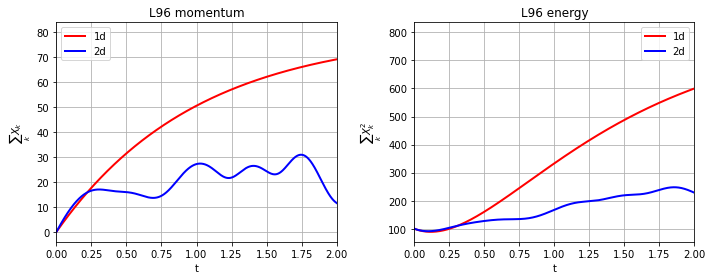

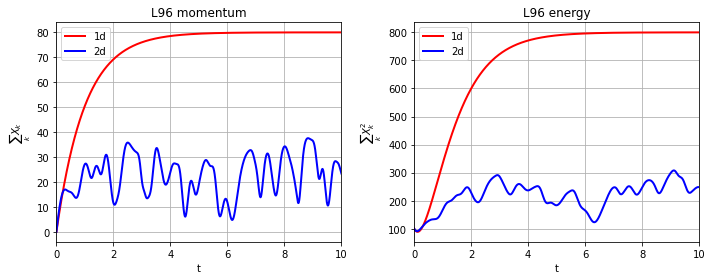

In [6]:
for tup in [2, T]:
    F, ax = plt.subplots(1, 2, figsize=(10, 4))

    a = ax.ravel()[0]
    a.plot(t1d, np.sum(x1d, axis=1), label="1d", color="r", linewidth=2)
    a.plot(t2d, np.sum(x2d, axis=1), label="2d", color="b", linewidth=2)
    a.legend()
    a.grid(True)
    a.set_title("L96 momentum")
    a.set_xlabel("t")
    a.set_ylabel(r"$\sum_k X_k$")
    a.set_xlim(0, tup)

    a = ax.ravel()[1]
    a.plot(t1d, np.sum(x1d**2, axis=1), label="1d", color="r", linewidth=2)
    a.plot(t2d, np.sum(x2d**2, axis=1), label="2d", color="b", linewidth=2)
    a.legend()
    a.grid(True)
    a.set_title("L96 energy")
    a.set_xlabel("t")
    a.set_ylabel(r"$\sum_k X_k^2$")
    a.set_xlim(0, tup)

    F.tight_layout();

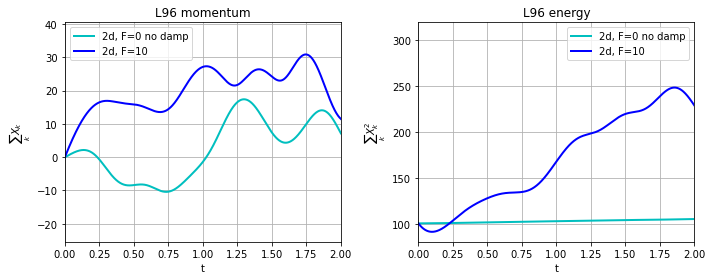

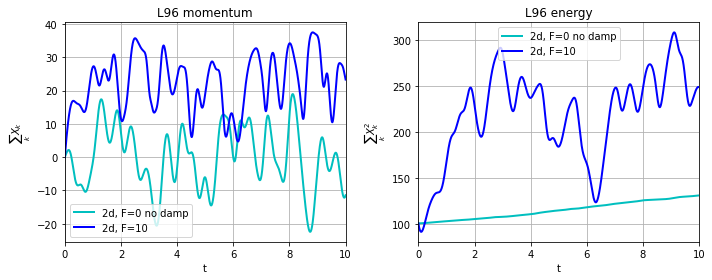

In [7]:
# Zero the forcing
Forcing_demo = 0
# Zero the damping via a linear parameterization term:
P_nodamp = [1.0, 0.0]

# Running the 2d and 1d versions of the GCM and GCM with squared forcing ("s")

gcm_2d_demo = GCM(Forcing_demo, naive_parameterization)
# The parameterization here is countering the decay term to demonstrate the conservation of this system
x2d_demo, t2d_demo = gcm_2d_demo(init_cond, dt, int(T / dt), P_nodamp)


for tup in [2, T]:
    F, ax = plt.subplots(1, 2, figsize=(10, 4))

    a = ax.ravel()[0]
    a.plot(
        t2d_demo,
        np.sum(x2d_demo, axis=1),
        label="2d, F=0 no damp",
        color="c",
        linewidth=2,
    )
    a.plot(t2d, np.sum(x2d, axis=1), label="2d, F=10", color="b", linewidth=2)
    a.legend()
    a.grid(True)
    a.set_title("L96 momentum")
    a.set_xlabel("t")
    a.set_ylabel(r"$\sum_k X_k$")
    a.set_xlim(0, tup)

    a = ax.ravel()[1]
    a.plot(
        t2d_demo,
        np.sum(x2d_demo**2, axis=1),
        label="2d, F=0 no damp",
        color="c",
        linewidth=2,
    )
    a.plot(t2d, np.sum(x2d**2, axis=1), label="2d, F=10", color="b", linewidth=2)
    a.legend()
    a.grid(True)
    a.set_title("L96 energy")
    a.set_xlabel("t")
    a.set_ylabel(r"$\sum_k X_k^2$")
    a.set_xlim(0, tup)

    F.tight_layout();

In [8]:
N = 50000

X = []
Xm1 = []
Xm2 = []
Xp1 = []
Adv = []

# randomize the initial condition and run 1000 time-step spin up with the real world model
init_condr = 10 * np.random.randn(8)
x_2, _ = gcm_2d(
    init_condr,
    0.001,
    1000,
    [
        0.0,
    ],
)

for ti in range(N):

    # Set the initial condition from the spin up/2d model
    init_condr_up = x_2[-1, :]

    # Real world values
    x_2, _ = gcm_2d(
        init_condr_up,
        0.001,
        1,
        [
            0.0,
        ],
    )
    # Simple model values
    x_1, _ = gcm_1d(
        init_condr_up,
        0.001,
        1,
        [
            0.0,
        ],
    )

    # This is the difference in the tendency term due to neglecting 2d processes per time-step
    Adv.append((x_2[-1, :] - x_1[-1, :]).ravel() / 0.001)

    # Storing the state variable and its rolled forms for plotting and learning convenience
    X.append(x_1[-1, :].ravel())
    Xm1.append(np.roll(x_1[-1, :], 1).ravel())
    Xm2.append(np.roll(x_1[-1, :], 2).ravel())
    Xp1.append(np.roll(x_1[-1, :], -1).ravel())

X = np.array(X)
Xm1 = np.array(Xm1)
Xm2 = np.array(Xm2)
Xp1 = np.array(Xp1)
Adv = np.array(Adv)

Text(0, 0.5, 'Advection')

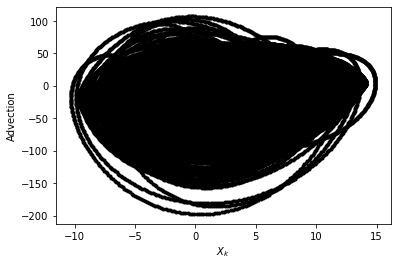

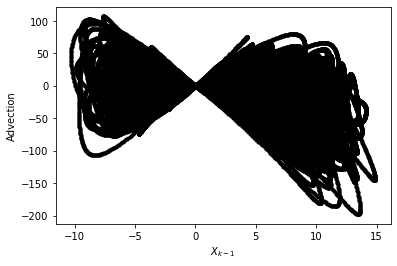

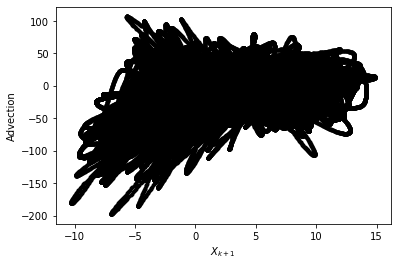

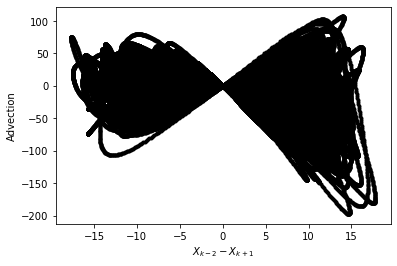

In [9]:
plt.figure()
plt.plot(X, Adv, "k.")
plt.xlabel("$X_{k}$")
plt.ylabel("Advection")

plt.figure()
plt.plot(Xm1, Adv, "k.")
plt.xlabel("$X_{k-1}$")
plt.ylabel("Advection")

plt.figure()
plt.plot(Xp1, Adv, "k.")
plt.xlabel("$X_{k+1}$")
plt.ylabel("Advection")

plt.figure()
plt.plot(Xm2 - Xp1, Adv, "k.")
plt.xlabel("$X_{k-2}-X_{k+1}$")
plt.ylabel("Advection")

Fit (slope/bias):  [ 1.00106922 -0.00702601]


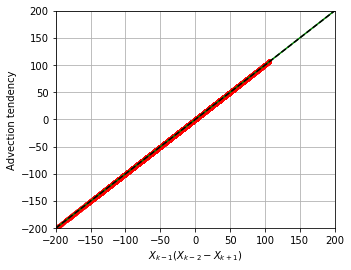

In [10]:
# We are going to assume we know the feature variable that we need to train the model.
# However, because of sampling across a time-step we will not fit a perfect 1:1,
# we end up with something very close to 1:1, but we will use a higher order polynomial that will
# fail when used outside the training data.

plt.figure(figsize=(5, 4))
Feature = -Xm1 * (np.array(Xm2) - np.array(Xp1))
plt.plot(Feature, Adv, "r.")
plt.xlabel("$X_{k-1}(X_{k-2}-X_{k+1})$")
plt.ylabel("Advection tendency")

# Here use a 10th order polynomial that is it to the advection tendencies.
# This parameterization will probably fail when used outside of the training data.
P = np.polyfit(np.array(Feature).ravel(), np.array(Adv).ravel(), 1)
print("Fit (slope/bias): ", P)
FS = [-200, 200]
plt.plot(FS, np.polyval(P, FS), "g-", label="polynomial parameterization")
plt.plot(FS, FS, "k--", label="1:1")
plt.xlim(-200, 200)
plt.ylim(-200, 200)
plt.grid(True)

In [11]:
# Create a new 1d GCM with a parameterization for the advection based on the known advection parameter
advection_parameterization = lambda param, X, F: np.polyval(
    param, -np.roll(X, 1) * (np.roll(X, 2) - np.roll(X, -1))
)
gcm_1d_padv = GCM_1d(Forcing, advection_parameterization)
gcm_1d_padv_x10 = GCM_1d(Forcing_x10, advection_parameterization)

# Here is the 1d GCM with the learned advection via the linear parameterization
xplinear, tplinear = gcm_1d_padv(init_cond, dt, int(T / dt), P)

# And the same 1d GCM applied out of sample
xplinear_x10, tplinear_x10 = gcm_1d_padv_x10(init_cond, dt, int(T / dt), P)

/tmp/ipykernel_2667/2415865238.py:3: RuntimeWarning: overflow encountered in multiply
  param, -np.roll(X, 1) * (np.roll(X, 2) - np.roll(X, -1))
/usr/share/miniconda/envs/L96M2lines/lib/python3.9/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


In [12]:
def CompExps(Exp1, ExpN):
    # Exp1 - reference experiment list
    # ExpN - list of comparison experiments

    try:
        T1 = Exp1[0]
        X1 = Exp1[1]
        L1 = Exp1[2]
        F, ax = plt.subplots(1, 2, figsize=(10, 4))
        a = ax.ravel()[0]
        a.plot(T1, np.sum(X1, axis=1), label=L1, color="k", linewidth=3)
        a = ax.ravel()[1]
        a.plot(T1, np.sum(X1**2, axis=1), label=L1, color="k", linewidth=3)

        F2, ax2 = plt.subplots(1, figsize=(5, 4))

        for Exp in ExpN:
            TN = Exp[0]
            XN = Exp[1]
            LN = Exp[2]

            a = ax.ravel()[0]
            a.plot(TN, np.sum(XN, axis=1), label=LN, linewidth=2)
            a = ax.ravel()[1]
            a.plot(TN, np.sum(XN**2, axis=1), label=LN, linewidth=2)

            _X = []
            _Y = []
            for ii in range(1, 100, 1):
                _X.append(np.percentile(np.sum(X1[int(5 // dt) :] ** 2, axis=1), ii))
                _Y.append(np.percentile(np.sum(XN[int(5 // dt) :] ** 2, axis=1), ii))
            ax2.plot(_X, _Y, ".-", label=LN)

        for ii in range(2):
            a = ax.ravel()[ii]
            a.legend()
            a.grid(True)
        ax[0].set(ylabel=r"$\sum_k X_k$", xlabel=r"$t$")
        ax[1].set(ylabel=r"$\sum_k X_k^2$", xlabel=r"$t$")
        F.tight_layout()

        ax2.grid(True)
        ax2.set(
            xlabel="e 2d model",
            ylabel="e 1d model w/ param",
            title="q-q plot of energy in 2d and parameterized model",
        )
        LIM = np.nanmax(list(_X) + list(_Y))
        ax2.set_xlim(0, LIM * 1.1)
        ax2.set_ylim(0, LIM * 1.1)
        ax2.plot([0, LIM], [0, LIM], "y-")
        pass
    except:
        pass

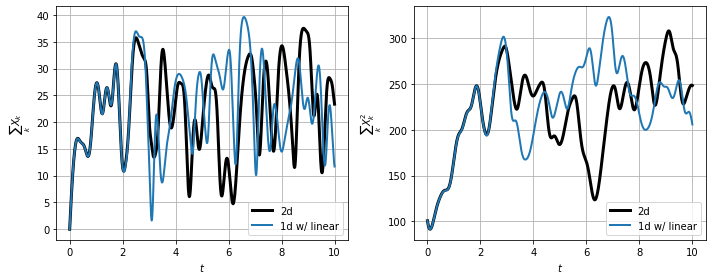

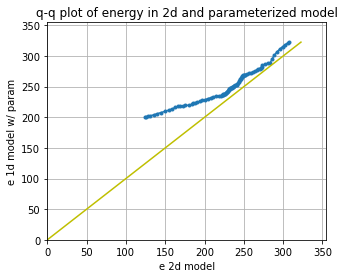

In [13]:
CompExps(
    [t2d, x2d, "2d"],
    [
        [tplinear, xplinear, "1d w/ linear"],
    ],
)

/usr/share/miniconda/envs/L96M2lines/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipykernel_2667/2792372065.py:13: RuntimeWarning: overflow encountered in square
  a.plot(T1, np.sum(X1**2, axis=1), label=L1, color="k", linewidth=3)
/tmp/ipykernel_2667/2792372065.py:25: RuntimeWarning: overflow encountered in square
  a.plot(TN, np.sum(XN**2, axis=1), label=LN, linewidth=2)
/tmp/ipykernel_2667/2792372065.py:31: RuntimeWarning: overflow encountered in square
  _Y.append(np.percentile(np.sum(XN[int(5 // dt) :] ** 2, axis=1), ii))


/tmp/ipykernel_2667/2792372065.py:48: RuntimeWarning: All-NaN axis encountered
  LIM = np.nanmax(list(_X) + list(_Y))


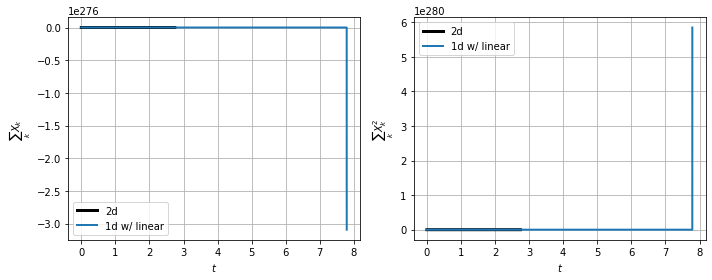

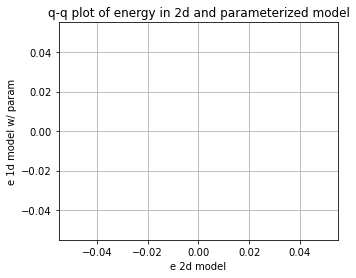

In [14]:
CompExps(
    [t2d_x10, x2d_x10, "2d"],
    [
        [tplinear_x10, xplinear_x10, "1d w/ linear"],
    ],
)

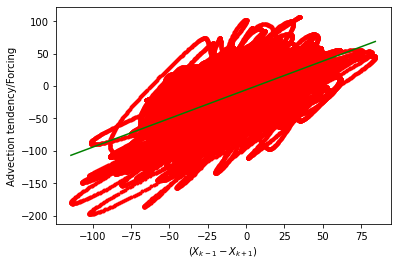

In [15]:
# Now we use a feature that is wrong to train the model

plt.figure()
Feature = -(np.array(Xm2) - np.array(Xp1) * np.array(Xm1))
plt.plot(Feature, Adv, "r.")
plt.xlabel("$(X_{k-1}-X_{k+1})$")
plt.ylabel("Advection tendency/Forcing")

# Here use a 10th order polynomial that is it to the advection tendencies.
# This parameterization will probably fail when used outside of the training data.
P_wrong = np.polyfit(np.array(Feature).ravel(), np.array(Adv).ravel(), 1)
FS = np.sort(np.array(Feature).ravel())
plt.plot(FS, np.polyval(P_wrong, FS), "g-", label="polynomial parameterization");

/tmp/ipykernel_2667/2520304281.py:3: RuntimeWarning: overflow encountered in multiply
  param, -(np.roll(X, 2) - np.roll(X, -1) * np.roll(X, 1))
/tmp/ipykernel_2667/2792372065.py:25: RuntimeWarning: overflow encountered in square
  a.plot(TN, np.sum(XN**2, axis=1), label=LN, linewidth=2)
/tmp/ipykernel_2667/2792372065.py:31: RuntimeWarning: overflow encountered in square
  _Y.append(np.percentile(np.sum(XN[int(5 // dt) :] ** 2, axis=1), ii))


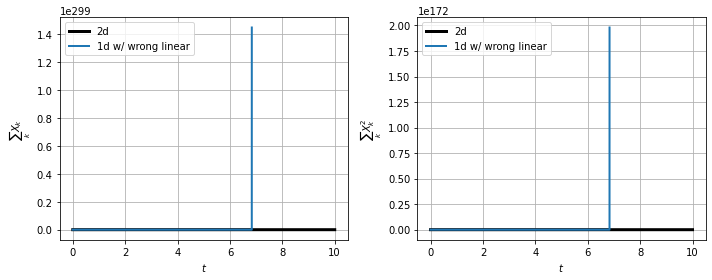

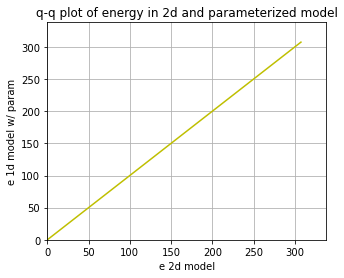

In [16]:
# Create a new 1d GCM with a 2d parameterization
advection_parameterization_wrong = lambda param, X, F: np.polyval(
    param, -(np.roll(X, 2) - np.roll(X, -1) * np.roll(X, 1))
)
gcm_1d_padv_wrong = GCM_1d(Forcing, advection_parameterization_wrong)

# Here is the 1d GCM with the learned advection via the 10th order polynomial
x_wrongp, t_wrongp = gcm_1d_padv_wrong(init_cond, dt, int(T / dt), P_wrong)

CompExps(
    [t2d, x2d, "2d"],
    [
        [t_wrongp, x_wrongp, "1d w/ wrong linear"],
    ],
)

In [17]:
import torch
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from sklearn.metrics import r2_score
from torch import nn, optim
from torch.autograd import Variable
from torch_lr_finder import LRFinder

np.random.seed(14)  # For reproducibility
torch.manual_seed(14)  # For reproducibility

Advection RMS: 29.446361959446467
X RMS: 5.014596660970016
Scaled Advection RMS: 0.29446361959446465
Scaled X RMS: 0.5014596660970017


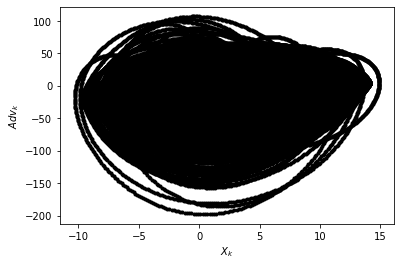

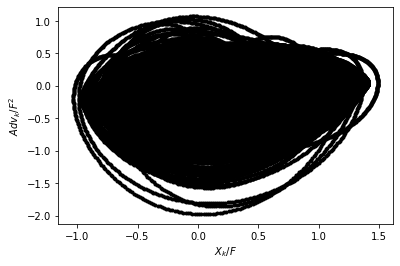

In [18]:
plt.figure()
plt.plot(X, Adv, "k.")
plt.xlabel("$X_k$")
plt.ylabel("$Adv_k$")

X_F = X / Forcing
Adv_F = Adv / Forcing**2

print("Advection RMS:", np.sqrt(np.mean(Adv**2)))
print("X RMS:", np.sqrt(np.mean(X**2)))

plt.figure()
plt.plot(X_F, Adv_F, "k.")
plt.xlabel("$X_k/F$")
plt.ylabel("$Adv_k/F^2$")

print("Scaled Advection RMS:", np.sqrt(np.mean(Adv_F**2)))
print("Scaled X RMS:", np.sqrt(np.mean(X_F**2)))

In [19]:
# Split into 80% training and 20% testing.

L = int(len(X) * 0.8)

# Create non local training data
# Define a data loader (8 inputs, 8 outputs)

# Define our X,Y pairs (state, subgrid tendency) for the linear regression local network.local_torch_dataset = Data.TensorDataset(
torch_dataset = Data.TensorDataset(
    torch.from_numpy(np.array(X_F[:L])).double(),
    torch.from_numpy(np.array(Adv_F[:L])).double(),
)

BATCH_SIZE = 1024  # Number of sample in each batch

loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True)


print("N training data: ", len(X_F[:L]))

N training data:  40000


In [20]:
print("N testing data: ", len(X_F[L:]))

# Define a test dataloader (8 inputs, 8 outputs)

torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(np.array(X_F[L:])).double(),
    torch.from_numpy(np.array(Adv_F[L:])).double(),
)

loader_test = Data.DataLoader(
    dataset=torch_dataset_test, batch_size=BATCH_SIZE, shuffle=True
)

N testing data:  10000


In [21]:
# define network structure in pytorch
import torch.nn.functional as FF


class Net_ANN(nn.Module):
    def __init__(self):
        super(Net_ANN, self).__init__()
        self.linear1 = nn.Linear(8, 16)  # 8 inputs, 16 neurons for first hidden layer
        self.linear2 = nn.Linear(16, 16)  # 16 neurons for second hidden layer
        self.linear3 = nn.Linear(16, 8)  # 8 outputs
        # self.lin_drop = nn.Dropout(0.1) #regularization method to prevent overfitting.

    def forward(self, x):
        x = FF.relu(self.linear1(x))
        x = FF.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [22]:
def train_model(net, criterion, trainloader, optimizer):
    net.train()
    test_loss = 0
    for step, (batch_x, batch_y) in enumerate(trainloader):  # for each training step
        b_x = Variable(batch_x)  # Inputs
        b_y = Variable(batch_y)  # outputs
        if (
            len(b_x.shape) == 1
        ):  # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
            prediction = torch.squeeze(
                net(torch.unsqueeze(b_x, 1))
            )  # input x and predict based on x
        else:
            prediction = net(b_x)
        loss = criterion(prediction, b_y)  # Calculating loss
        optimizer.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients to update weights


def test_model(net, criterion, trainloader, optimizer, text="validation"):
    net.eval()  # Evaluation mode (important when having dropout layers)
    test_loss = 0
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(
            trainloader
        ):  # for each training step
            b_x = Variable(batch_x)  # Inputs
            b_y = Variable(batch_y)  # outputs
            if (
                len(b_x.shape) == 1
            ):  # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
                prediction = torch.squeeze(
                    net(torch.unsqueeze(b_x, 1))
                )  # input x and predict based on x
            else:
                prediction = net(b_x)
            loss = criterion(prediction, b_y)  # Calculating loss
            test_loss = test_loss + loss.data.numpy()  # Keep track of the loss
        test_loss /= len(trainloader)  # dividing by the number of batches
        #         print(len(trainloader))
        print(text + " loss:", test_loss)
    return test_loss


criterion = torch.nn.MSELoss()  # MSE loss function

In [23]:
torch.manual_seed(14)  # For reproducibility
nn_3l = Net_ANN().double()

train loss: 0.023976454211719102
validation loss: 0.02673119752887406


train loss: 0.013548915009697524
validation loss: 0.01724920747480611


train loss: 0.011875283148444318
validation loss: 0.01665746130156205


train loss: 0.010777243845649927
validation loss: 0.015769941262796936


train loss: 0.010789502187056524
validation loss: 0.015786570131707315


train loss: 0.010251383676629512
validation loss: 0.01619038256391348


train loss: 0.01020982335849303
validation loss: 0.015248259804410021


train loss: 0.00969203436150072
validation loss: 0.01441536606742217


train loss: 0.0095161944001536
validation loss: 0.013759952638541786


train loss: 0.009144298023152675
validation loss: 0.013131917115381513


train loss: 0.009235734491757774
validation loss: 0.013796228045852529


train loss: 0.00907707911416145
validation loss: 0.013012376723814395


train loss: 0.009231200450345835
validation loss: 0.012701172725695847


train loss: 0.009074426797564414
validation loss: 0.012721917154223907


train loss: 0.009270021121154708
validation loss: 0.012992712107342912


train loss: 0.009916953233571833
validation loss: 0.014302529120773658


train loss: 0.008843983827294403
validation loss: 0.01278543667919399


train loss: 0.008627414463128594
validation loss: 0.012103836108980064


train loss: 0.009113748673342515
validation loss: 0.013643258238673022


train loss: 0.00873210697453493
validation loss: 0.012556794228861029


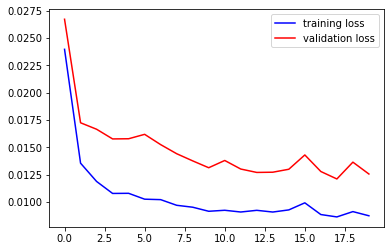

In [24]:
n_epochs = 20  # Number of epocs
optimizer = optim.Adam(nn_3l.parameters(), lr=0.03)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l, criterion, loader, optimizer)
    train_loss.append(test_model(nn_3l, criterion, loader, optimizer, "train"))
    validation_loss.append(test_model(nn_3l, criterion, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

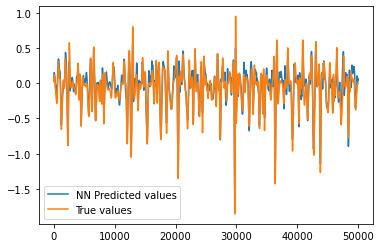

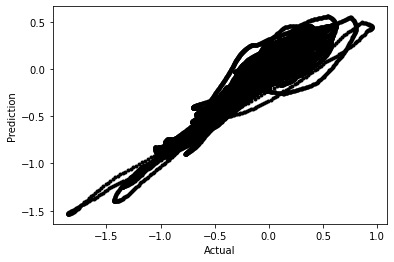

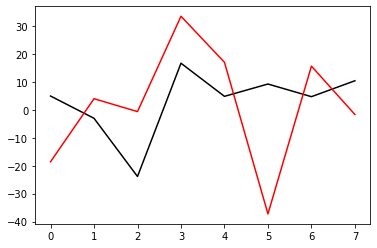

In [25]:
# The neural network does a pretty good job predicting the advection tendencies

preds22 = nn_3l(torch.from_numpy(np.array(X_F)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[0:, 2], label="NN Predicted values")
plt.plot(Adv_F[:, 2], label="True values")
plt.legend()

plt.figure()
plt.plot(Adv_F[:, 2], preds22.detach().numpy()[0:, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")
pass

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = nn_3l(torch.from_numpy(np.array(Xt / Forcing)).double()).detach().numpy()

plt.figure()
plt.plot(Advr, "k-")
plt.plot(nnAdv * Forcing**2, "r-")

In [26]:
# - a GCM class including a neural network parameterization in rhs of equation for tendency
class GCM_network:
    def __init__(self, F, network, time_stepping=time_method):
        self.F = F
        self.network = network
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        if self.network.linear1.in_features == 1:
            X_torch = torch.from_numpy(X / self.F).double()
            X_torch = torch.unsqueeze(X_torch, 1)
        else:
            X_torch = torch.from_numpy(np.expand_dims(X / self.F, 0)).double()
        return L96_eq1_xdot(
            X,
            self.F + self.F**2 * np.squeeze(self.network(X_torch).data.numpy()),
            advect=False,
        )  # Adding NN parameterization

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [27]:
# Run a test with the parameterization

gcm_nn = GCM_network(Forcing, nn_3l)
xnn, tnn = gcm_nn(init_cond, dt, int(T / (dt)), nn_3l)

gcm_nn_x10 = GCM_network(Forcing_x10, nn_3l)
xnn_x10, tnn_x10 = gcm_nn_x10(init_cond, dt, int(T / (dt)), nn_3l)

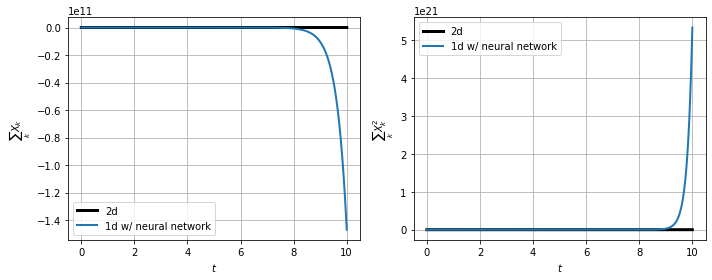

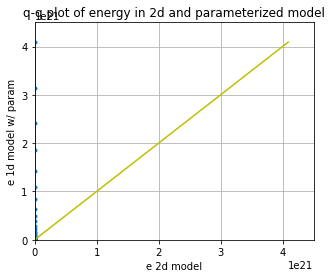

In [28]:
CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn, xnn, "1d w/ neural network"],
    ],
)

/usr/share/miniconda/envs/L96M2lines/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipykernel_2667/2792372065.py:13: RuntimeWarning: overflow encountered in square
  a.plot(T1, np.sum(X1**2, axis=1), label=L1, color="k", linewidth=3)


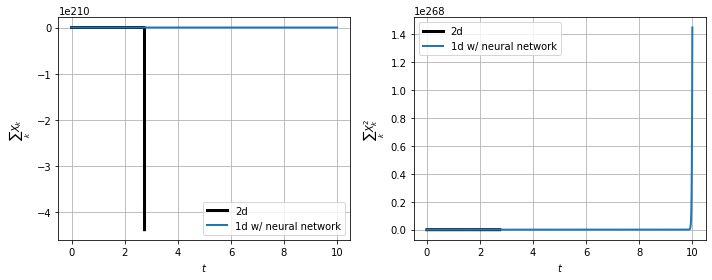

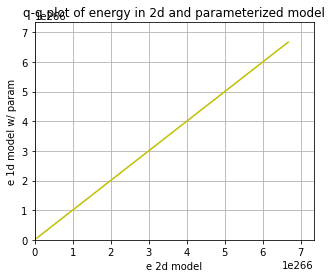

In [29]:
CompExps(
    [t2d_x10, x2d_x10, "2d"],
    [
        [tnn_x10, xnn_x10, "1d w/ neural network"],
    ],
)

In [30]:
def my_loss2(inpt, output, target):
    # In which we add conservation of "momentum" to our loss function
    loss = torch.mean(2 * (output - target) ** 2) + torch.mean(
        torch.sum(output, axis=1) ** 2
    )
    return loss

In [31]:
def train_model2(net, criterion, trainloader, optimizer):
    net.train()
    test_loss = 0
    for step, (batch_x, batch_y) in enumerate(trainloader):  # for each training step
        b_x = Variable(batch_x)  # Inputs
        b_y = Variable(batch_y)  # outputs
        if (
            len(b_x.shape) == 1
        ):  # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
            prediction = torch.squeeze(
                net(torch.unsqueeze(b_x, 1))
            )  # input x and predict based on x
        else:
            prediction = net(b_x)
        loss = criterion(b_x, prediction, b_y)  # Calculating loss
        optimizer.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients to update weights


def test_model2(net, criterion, trainloader, optimizer, text="validation"):
    net.eval()  # Evaluation mode (important when having dropout layers)
    test_loss = 0
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(
            trainloader
        ):  # for each training step
            b_x = Variable(batch_x)  # Inputs
            b_y = Variable(batch_y)  # outputs
            if (
                len(b_x.shape) == 1
            ):  # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
                prediction = torch.squeeze(
                    net(torch.unsqueeze(b_x, 1))
                )  # input x and predict based on x
            else:
                prediction = net(b_x)
            loss = criterion(b_x, prediction, b_y)  # Calculating loss
            test_loss = test_loss + loss.data.numpy()  # Keep track of the loss
        test_loss /= len(trainloader)  # dividing by the number of batches
        #         print(len(trainloader))
        print(text + " loss:", test_loss)
    return test_loss

In [32]:
torch.manual_seed(14)  # For reproducibility
nn_3l_loss2 = Net_ANN().double()

train loss: 0.12433913969333972
validation loss: 0.15199392485487945


train loss: 0.08100169896268185
validation loss: 0.09558658226815105


train loss: 0.06291612152690175
validation loss: 0.07623145692042661


train loss: 0.05210516305882192
validation loss: 0.061560440295460706


train loss: 0.04573591349003783
validation loss: 0.05256580647344211


train loss: 0.04344983972666622
validation loss: 0.05163744679667141


train loss: 0.04238802859724879
validation loss: 0.0512881516633548


train loss: 0.042009106112952437
validation loss: 0.05068892148492229


train loss: 0.03688825717762324
validation loss: 0.04570437114633026


train loss: 0.03706318359708195
validation loss: 0.045017113584828


train loss: 0.035973419182835406
validation loss: 0.04417522323992538


train loss: 0.0350912769941614
validation loss: 0.04333125191499729


train loss: 0.03454805145439986
validation loss: 0.04233789244133305


train loss: 0.03424875998701406
validation loss: 0.04251279095665013


train loss: 0.03637885826131293
validation loss: 0.044354283893403235


train loss: 0.03413811803167283
validation loss: 0.04218184038447095


train loss: 0.035546721333896386
validation loss: 0.04385875390817745


train loss: 0.03419876326887208
validation loss: 0.04214357046072452


train loss: 0.034755962742288954
validation loss: 0.04308050547564203


train loss: 0.03340002398432364
validation loss: 0.04194113029024144


train loss: 0.03504093810795515
validation loss: 0.044622728889393906


train loss: 0.03382636287564753
validation loss: 0.042749146118339784


train loss: 0.034702614374111214
validation loss: 0.043359774962505315


train loss: 0.034239995416868264
validation loss: 0.043493593227377975


train loss: 0.03344308965009013
validation loss: 0.04272359519020935


train loss: 0.033695561949768735
validation loss: 0.04186015756488144


train loss: 0.03420606580486611
validation loss: 0.04320089844563503


train loss: 0.03356355775801583
validation loss: 0.04218803944680377


train loss: 0.032711789794148904
validation loss: 0.041337921860435785


train loss: 0.033820612351441334
validation loss: 0.04187843351414748


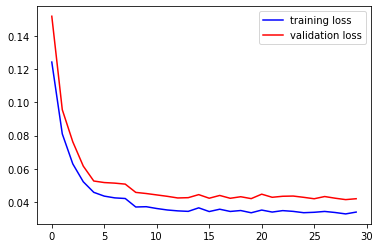

In [33]:
n_epochs = 30  # Number of epocs
optimizer = optim.Adam(nn_3l_loss2.parameters(), lr=0.02)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model2(nn_3l_loss2, my_loss2, loader, optimizer)
    train_loss.append(test_model2(nn_3l_loss2, my_loss2, loader, optimizer, "train"))
    validation_loss.append(test_model2(nn_3l_loss2, my_loss2, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

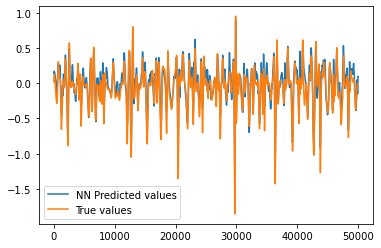

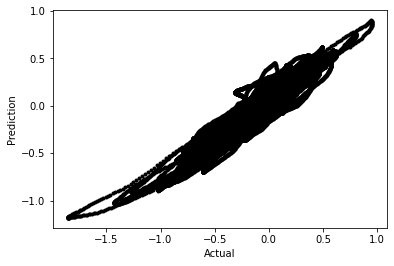

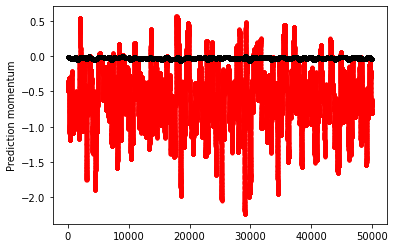

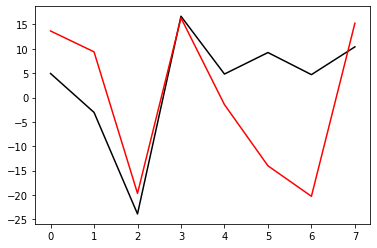

In [34]:
# The neural network does a pretty good job predicting the advection tendencies

preds22o = nn_3l(torch.from_numpy(np.array(X_F)).double())
preds22 = nn_3l_loss2(torch.from_numpy(np.array(X_F)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[0:, 2], label="NN Predicted values")
plt.plot(Adv_F[:, 2], label="True values")
plt.legend()

plt.figure()
plt.plot(Adv_F[:, 2], preds22.detach().numpy()[0:, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")

plt.figure()
plt.plot(np.sum(preds22o.detach().numpy(), axis=1), "r.")
plt.plot(np.sum(preds22.detach().numpy(), axis=1), "k.")
plt.ylabel("Prediction momentum")

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = nn_3l_loss2(torch.from_numpy(np.array(Xt / Forcing)).double()).detach().numpy()

plt.figure()
plt.plot(Advr, "k-", label="actual")
plt.plot(nnAdv * Forcing**2, "r-", label="predicted")
pass;

In [35]:
gcm_nn2 = GCM_network(Forcing, nn_3l_loss2)
xnn2, tnn2 = gcm_nn2(init_cond, dt, int(T / (dt)), nn_3l_loss2)

gcm_nn2_x10 = GCM_network(Forcing_x10, nn_3l_loss2)
xnn2_x10, tnn2_x10 = gcm_nn2_x10(init_cond, dt, int(T / (dt)), nn_3l_loss2)

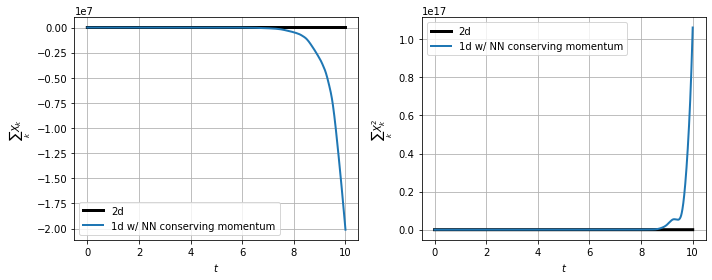

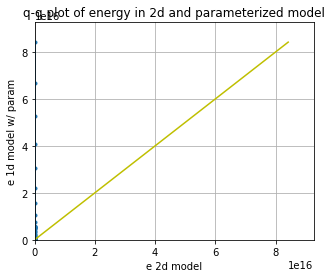

In [36]:
CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn2, xnn2, "1d w/ NN conserving momentum"],
    ],
)

/tmp/ipykernel_2667/2792372065.py:13: RuntimeWarning: overflow encountered in square
  a.plot(T1, np.sum(X1**2, axis=1), label=L1, color="k", linewidth=3)


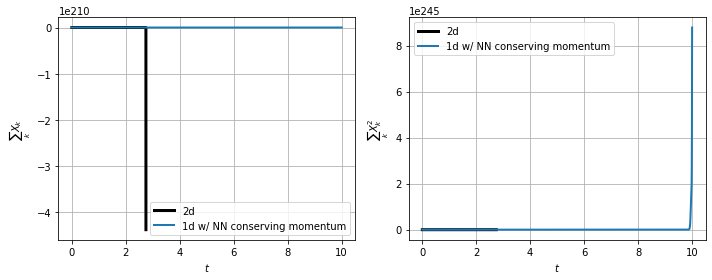

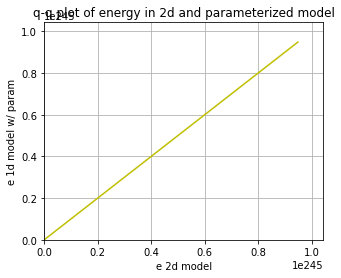

In [37]:
CompExps(
    [t2d_x10, x2d_x10, "2d"],
    [
        [tnn2_x10, xnn2_x10, "1d w/ NN conserving momentum"],
    ],
)

In [38]:
torch.manual_seed(14)  # For reproducibility
nn_3l_loss3 = Net_ANN().double()

train loss: 0.1484983630279433
validation loss: 0.1931884305272666


train loss: 0.1319253119145367
validation loss: 0.16888181532321095


train loss: 0.12614149195986565
validation loss: 0.15780259832502286


train loss: 0.12310192076150335
validation loss: 0.15164824386180067


train loss: 0.12203800403865042
validation loss: 0.15044723956435382


train loss: 0.11997821447729676
validation loss: 0.14704300190979133


train loss: 0.11847987978167558
validation loss: 0.14306720040827897


train loss: 0.11642477117328645
validation loss: 0.14054864335289968


train loss: 0.11568718230864568
validation loss: 0.14032510305562376


train loss: 0.11598379351012249
validation loss: 0.13988873624146345


train loss: 0.11500424549167063
validation loss: 0.13870725708276727


train loss: 0.1148653508865958
validation loss: 0.13786588218702203


train loss: 0.11463695235916893
validation loss: 0.1385273471559052


train loss: 0.11463017424896345
validation loss: 0.13794790092644363


train loss: 0.1143090010456915
validation loss: 0.13797136429843732


train loss: 0.11333847636574919
validation loss: 0.13576769066327693


train loss: 0.11340582141397097
validation loss: 0.13669788298775093


train loss: 0.11398448994479035
validation loss: 0.1363731224449301


train loss: 0.11335043043258039
validation loss: 0.13671914904958984


train loss: 0.11330630609576889
validation loss: 0.13690032912839417


train loss: 0.11242566994795303
validation loss: 0.13555043745345952


train loss: 0.11313718393617715
validation loss: 0.13595716474589462


train loss: 0.11347031901169127
validation loss: 0.1366283538023535


train loss: 0.11263358757810146
validation loss: 0.13500644363191136


train loss: 0.11284235299141965
validation loss: 0.13657545253908907


train loss: 0.11318584715804055
validation loss: 0.135464391710533


train loss: 0.11218895128032916
validation loss: 0.1344461119181663


train loss: 0.1131508777424807
validation loss: 0.13559417578041438


train loss: 0.11341474525571413
validation loss: 0.1362080781669152


train loss: 0.11372559344485644
validation loss: 0.1362338383036853


train loss: 0.1135133260162708
validation loss: 0.13664550855484192


train loss: 0.113872805588592
validation loss: 0.13749621387562455


train loss: 0.11333824964467765
validation loss: 0.13647770734607823


train loss: 0.1132766531411151
validation loss: 0.13607211793620752


train loss: 0.11358029922388262
validation loss: 0.1356770292541771


train loss: 0.11304165891352717
validation loss: 0.1356815711918584


train loss: 0.11252559065319075
validation loss: 0.13542895914055586


train loss: 0.11339232131607395
validation loss: 0.1365422038835265


train loss: 0.11356097001680861
validation loss: 0.13688779538638285


train loss: 0.11262224155277603
validation loss: 0.13507339399046145


train loss: 0.1123945990476829
validation loss: 0.13608081220398485


train loss: 0.11395736959827889
validation loss: 0.13640501746547973


train loss: 0.11334126144541812
validation loss: 0.136547685919764


train loss: 0.11370913573005526
validation loss: 0.13657173175917842


train loss: 0.11274547540410558
validation loss: 0.1354493325580637


train loss: 0.11323766730911237
validation loss: 0.13633986517411298


train loss: 0.11352886726884967
validation loss: 0.13711185388701658


train loss: 0.11241545008612219
validation loss: 0.13437863192828226


train loss: 0.11367941781682174
validation loss: 0.13737022420331255


train loss: 0.11293958949126064
validation loss: 0.13560566113525593


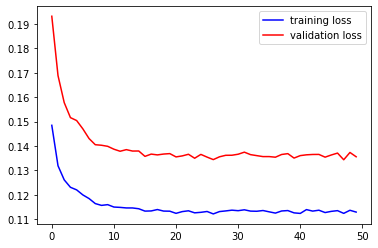

In [39]:
n_epochs = 50  # Number of epocs
optimizer = optim.Adam(nn_3l_loss3.parameters(), lr=0.01, weight_decay=0.01)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model2(nn_3l_loss3, my_loss2, loader, optimizer)
    train_loss.append(test_model2(nn_3l_loss3, my_loss2, loader, optimizer, "train"))
    validation_loss.append(test_model2(nn_3l_loss3, my_loss2, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

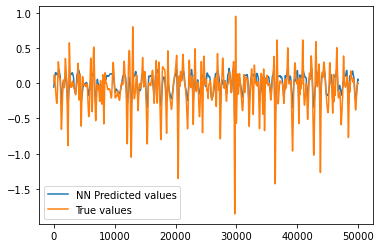

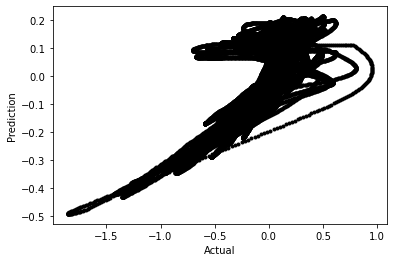

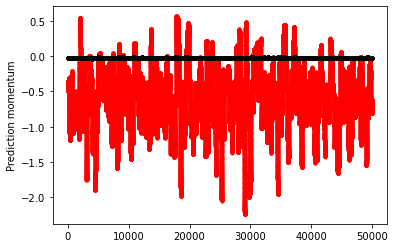

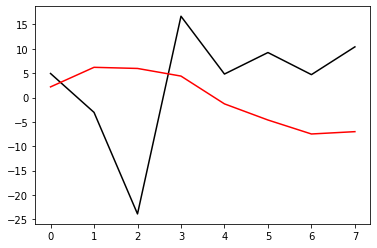

In [40]:
# The neural network does a pretty good job predicting the advection tendencies

preds22o = nn_3l(torch.from_numpy(np.array(X_F)).double())
preds22 = nn_3l_loss3(torch.from_numpy(np.array(X_F)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[0:, 2], label="NN Predicted values")
plt.plot(Adv_F[:, 2], label="True values")
plt.legend()

plt.figure()
plt.plot(Adv_F[:, 2], preds22.detach().numpy()[0:, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")

plt.figure()
plt.plot(np.sum(preds22o.detach().numpy(), axis=1), "r.")
plt.plot(np.sum(preds22.detach().numpy(), axis=1), "k.")
plt.ylabel("Prediction momentum")

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = nn_3l_loss3(torch.from_numpy(np.array(Xt / Forcing)).double()).detach().numpy()

plt.figure()
plt.plot(Advr, "k-", label="actual")
plt.plot(nnAdv * Forcing**2, "r-", label="predicted")
pass;

In [41]:
gcm_nn3 = GCM_network(Forcing, nn_3l_loss3)
xnn3, tnn3 = gcm_nn3(init_cond, dt, int(T / (dt)), nn_3l_loss3)

gcm_nn3_x10 = GCM_network(Forcing_x10, nn_3l_loss3)
xnn3_x10, tnn3_x10 = gcm_nn3_x10(init_cond, dt, int(T / (dt)), nn_3l_loss3)

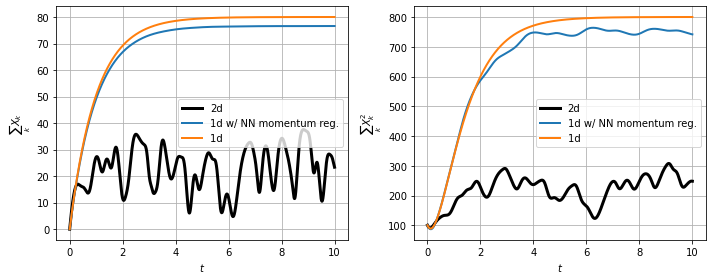

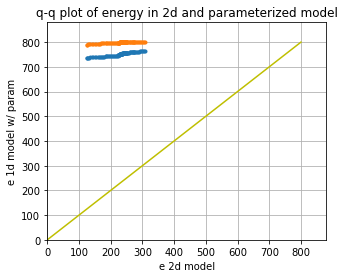

In [42]:
CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn3, xnn3, "1d w/ NN momentum reg."],
        [t1d, x1d, "1d "],
    ],
)

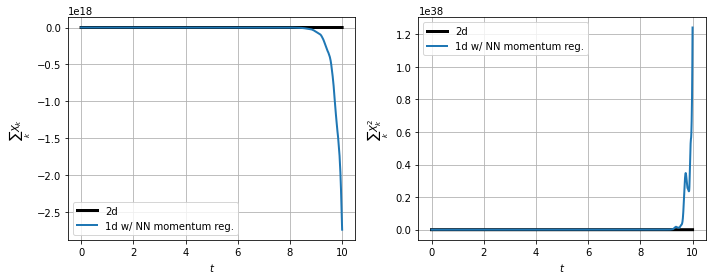

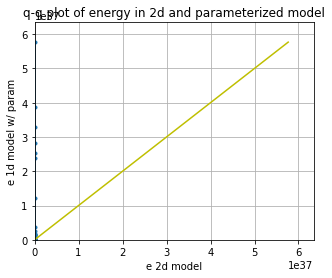

In [43]:
CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn3_x10, xnn3_x10, "1d w/ NN momentum reg."],
    ],
)

In [44]:
# Use the advection tendencies, splitting into 80% training and 20% testing.

L = int(len(X) * 0.8)
print(L)

ScX = np.sqrt(np.mean(X**2))
X_S = X / ScX
ScA = np.sqrt(np.mean(Adv**2))
Adv_S = Adv / ScA

# Create non local training data
# Define a data loader (8 inputs, 8 outputs)

# Define our X,Y pairs (state, subgrid tendency) for the linear regression local network.local_torch_dataset = Data.TensorDataset(
torch_dataset = Data.TensorDataset(
    torch.from_numpy(np.array(X_S[:L])).double(),
    torch.from_numpy(np.array(Adv_S[:L])).double(),
)

BATCH_SIZE = 1024  # Number of sample in each batch

loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define a test dataloader (8 inputs, 8 outputs)

torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(np.array(X_S[L:])).double(),
    torch.from_numpy(np.array(Adv_S[L:])).double(),
)

loader_test = Data.DataLoader(
    dataset=torch_dataset_test, batch_size=BATCH_SIZE, shuffle=True
)

40000


In [45]:
torch.manual_seed(14)  # For reproducibility
nn_3l_loss4 = Net_ANN().double()

train loss: 1.283056532274176
validation loss: 1.5050605393371643


train loss: 0.8920693224947522
validation loss: 0.9670791895502117


train loss: 0.6589233764696927
validation loss: 0.703074778020609


train loss: 0.5898067788382049
validation loss: 0.6487603844716577


train loss: 0.5435172032537773
validation loss: 0.6119867163106849


train loss: 0.5161053198967553
validation loss: 0.5942138509905084


train loss: 0.49510114466316624
validation loss: 0.5646254357431744


train loss: 0.4846945496392509
validation loss: 0.5534847840334212


train loss: 0.46799463397608665
validation loss: 0.5424217912138536


train loss: 0.4668420387206155
validation loss: 0.5374481439647082


train loss: 0.4623399168465766
validation loss: 0.5242781584929679


train loss: 0.45715253213395723
validation loss: 0.5180720095365827


train loss: 0.4559837995136461
validation loss: 0.5252250854419376


train loss: 0.45221987994414886
validation loss: 0.5116416845547999


train loss: 0.4521859106227664
validation loss: 0.5189413305056985


train loss: 0.4473388302413547
validation loss: 0.5099097782856481


train loss: 0.44917216288236317
validation loss: 0.5109078886755778


train loss: 0.4539241478278514
validation loss: 0.5174560972124675


train loss: 0.4450213200652068
validation loss: 0.5138853395693299


train loss: 0.446002561732542
validation loss: 0.5048084584234116


train loss: 0.44338276617849337
validation loss: 0.5072962961192504


train loss: 0.4446592834535168
validation loss: 0.5043964991130022


train loss: 0.4459567680841567
validation loss: 0.5079064765651485


train loss: 0.44368466718983635
validation loss: 0.5078050338768489


train loss: 0.4427362536265992
validation loss: 0.5099052316606704


train loss: 0.44215129323386587
validation loss: 0.4964464256729205


train loss: 0.44031213547640524
validation loss: 0.5036162639079311


train loss: 0.4423035730264033
validation loss: 0.5041627395121363


train loss: 0.44014803947438413
validation loss: 0.5008266255487908


train loss: 0.4448402507721908
validation loss: 0.5056767641935018


train loss: 0.44218231901412447
validation loss: 0.5003774674058895


train loss: 0.4380287073088728
validation loss: 0.5058426594654015


train loss: 0.43862716525282786
validation loss: 0.5022048311930876


train loss: 0.4377078503183863
validation loss: 0.5007234326108171


train loss: 0.43956456383857906
validation loss: 0.49945019132426055


train loss: 0.43743023682965176
validation loss: 0.49328874634885417


train loss: 0.4344462261924248
validation loss: 0.49428300282887044


train loss: 0.43327914618214736
validation loss: 0.4950386551381178


train loss: 0.433082966840144
validation loss: 0.49713659549261724


train loss: 0.4323842578504736
validation loss: 0.49800412337755107


train loss: 0.4305269025372757
validation loss: 0.48865784524295713


train loss: 0.43579787236210077
validation loss: 0.5002499153503204


train loss: 0.4304379051438397
validation loss: 0.49131273976127393


train loss: 0.43311194291229843
validation loss: 0.4936433483230617


train loss: 0.4293138156734052
validation loss: 0.49129697885287565


train loss: 0.42818575235656076
validation loss: 0.48645772030466994


train loss: 0.43291099660758237
validation loss: 0.4854623183572147


train loss: 0.42849397009856593
validation loss: 0.48377711900494924


train loss: 0.4301890135856013
validation loss: 0.490856868675447


train loss: 0.42871806968285997
validation loss: 0.4838803028248536


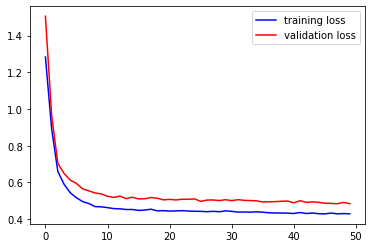

In [46]:
n_epochs = 50  # Number of epocs
optimizer = optim.Adam(nn_3l_loss4.parameters(), lr=0.01, weight_decay=0.02)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model2(nn_3l_loss4, my_loss2, loader, optimizer)
    train_loss.append(test_model2(nn_3l_loss4, my_loss2, loader, optimizer, "train"))
    validation_loss.append(test_model2(nn_3l_loss4, my_loss2, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

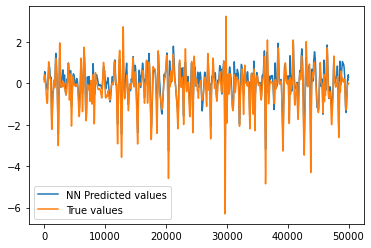

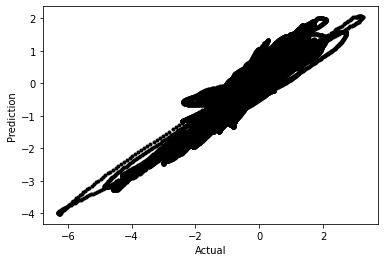

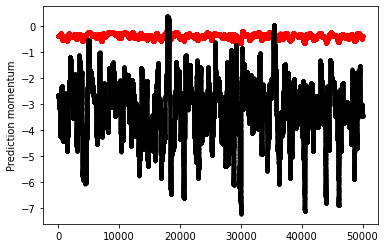

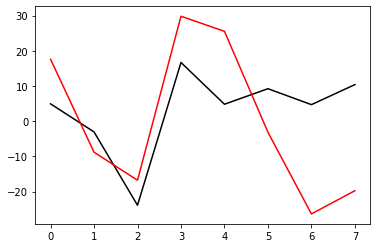

In [47]:
# The neural network does a pretty good job predicting the advection tendencies

preds22o = nn_3l_loss3(torch.from_numpy(np.array(X_S)).double())
preds22 = nn_3l_loss4(torch.from_numpy(np.array(X_S)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[0:, 2], label="NN Predicted values")
plt.plot(Adv_S[:, 2], label="True values")
plt.legend()

plt.figure()
plt.plot(Adv_S[:, 2], preds22.detach().numpy()[0:, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")

plt.figure()
plt.plot(np.sum(preds22o.detach().numpy(), axis=1) * Forcing, "r.")
plt.plot(np.sum(preds22.detach().numpy(), axis=1) * ScA, "k.")
plt.ylabel("Prediction momentum")

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = nn_3l_loss4(torch.from_numpy(np.array(Xt / Forcing)).double()).detach().numpy()

plt.figure()
plt.plot(Advr, "k-", label="actual")
plt.plot(nnAdv * Forcing**2, "r-", label="predicted")
pass;

In [48]:
# - a GCM class including a neural network parameterization in rhs of equation for tendency
class GCM_network_S:
    def __init__(self, F, network, time_stepping=time_method):
        self.F = F
        self.network = network
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        if self.network.linear1.in_features == 1:
            X_torch = torch.from_numpy(X / ScX).double()
            X_torch = torch.unsqueeze(X_torch, 1)
        else:
            X_torch = torch.from_numpy(np.expand_dims(X / ScX, 0)).double()
        return L96_eq1_xdot(
            X,
            self.F + ScA * np.squeeze(self.network(X_torch).data.numpy()),
            advect=False,
        )  # Adding NN parameterization

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [49]:
gcm_nn4 = GCM_network_S(Forcing, nn_3l_loss4)
xnn4, tnn4 = gcm_nn4(init_cond, dt, int(T / dt), nn_3l_loss4)

gcm_nn4_x10 = GCM_network_S(Forcing_x10, nn_3l_loss4)
xnn4_x10, tnn4_x10 = gcm_nn4_x10(init_cond, dt, int(T / dt), nn_3l_loss4)

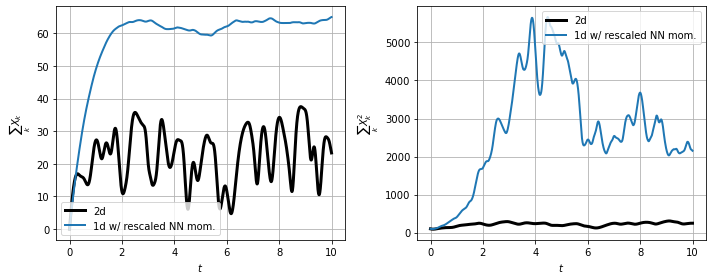

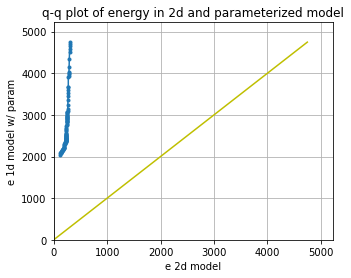

In [50]:
CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn4, xnn4, "1d w/ rescaled NN mom."],
    ],
)

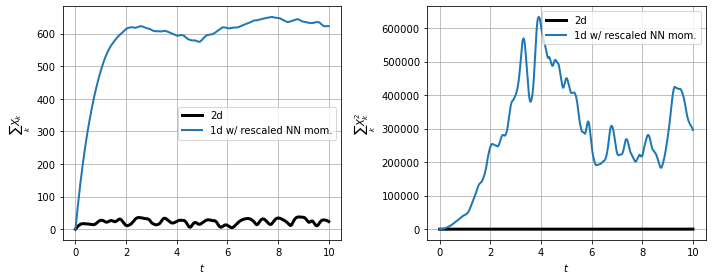

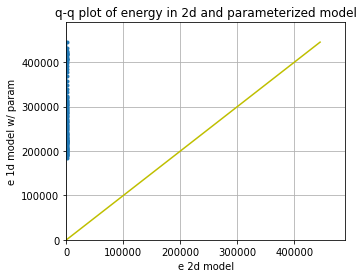

In [51]:
CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn4_x10, xnn4_x10, "1d w/ rescaled NN mom."],
    ],
)

In [52]:
def my_loss3(inpt, output, target):
    # In which we replace conservation of "momentum" with conservation of "energy"
    loss = torch.mean(2 * (output - target) ** 2) + WT * torch.mean(
        torch.sum(inpt * output, axis=1) ** 2
    )
    return loss

train loss: 1.1103186137439902
validation loss: 1.446341763366936


train loss: 0.7456689021180771
validation loss: 0.9749218128668522


train loss: 0.6241814222470717
validation loss: 0.8772678041947547


train loss: 0.5239597048996874
validation loss: 0.809187066705596


train loss: 0.49779440525197255
validation loss: 0.7806251061968366


train loss: 0.4700468978131208
validation loss: 0.8140023644558229


train loss: 0.4321600586924605
validation loss: 0.7934326497723211


train loss: 0.42382701370353093
validation loss: 0.7700842231179909


train loss: 0.3948642253400145
validation loss: 0.7768642807449208


train loss: 0.39964829073625924
validation loss: 0.7370380971862813


train loss: 0.3712491551685422
validation loss: 0.7554704314812215


train loss: 0.37283044678444227
validation loss: 0.8219949697106255


train loss: 0.35912353115951656
validation loss: 0.7732233807037521


train loss: 0.3577279346923849
validation loss: 0.7395490549592638


train loss: 0.34472772763283666
validation loss: 0.7319887075363245


train loss: 0.34813366364731796
validation loss: 0.7848937528471852


train loss: 0.3368088863616133
validation loss: 0.7184240195593394


train loss: 0.326798167774191
validation loss: 0.7301442881842678


train loss: 0.3348523748476969
validation loss: 0.706698235472232


train loss: 0.319050571460488
validation loss: 0.7266488748328108


train loss: 0.3593179041298845
validation loss: 0.7166130181865268


train loss: 0.31682294699486346
validation loss: 0.6721521743530575


train loss: 0.31169724519994957
validation loss: 0.6903907176610471


train loss: 0.31825214422959763
validation loss: 0.6787319845923141


train loss: 0.32407135443499785
validation loss: 0.6752954531561866


train loss: 0.2936096590551595
validation loss: 0.6742593551411287


train loss: 0.3248587695748442
validation loss: 0.6766525432424625


train loss: 0.3062261680196361
validation loss: 0.6782974197000302


train loss: 0.31016549918362396
validation loss: 0.6783194874019254


train loss: 0.3121164361157801
validation loss: 0.7110827870216904


train loss: 0.2966275647348029
validation loss: 0.707415615388131


train loss: 0.292240927130463
validation loss: 0.6615145105018077


train loss: 0.28870783351887264
validation loss: 0.6710823194602624


train loss: 0.2956020493058876
validation loss: 0.6753396784706949


train loss: 0.28413258072606046
validation loss: 0.6767062878731058


train loss: 0.28241112970474147
validation loss: 0.6742545507386597


train loss: 0.2871381438254519
validation loss: 0.6533382298846329


train loss: 0.28454586081662014
validation loss: 0.6797514055124423


train loss: 0.28192924101082106
validation loss: 0.68596725511168


train loss: 0.2806185317943335
validation loss: 0.6660673624728612


train loss: 0.281490457671231
validation loss: 0.6947175877471464


train loss: 0.2948819725196362
validation loss: 0.7205987184649514


train loss: 0.2968063212130939
validation loss: 0.7065372832297226


train loss: 0.3019679064511859
validation loss: 0.7097862765439387


train loss: 0.2988910515618508
validation loss: 0.7156383419100543


train loss: 0.2773889533225883
validation loss: 0.6801153999010644


train loss: 0.28302261740181883
validation loss: 0.687150598727657


train loss: 0.2793091268627798
validation loss: 0.7154400366435786


train loss: 0.2928557446872578
validation loss: 0.7095149075728004


train loss: 0.2795010831525286
validation loss: 0.6801174580467289


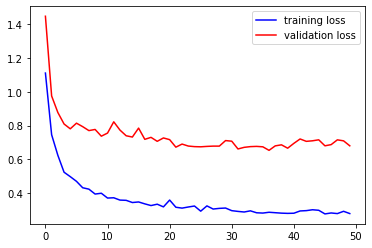

In [53]:
WT = 1

torch.manual_seed(14)  # For reproducibility
nn_3l_loss5 = Net_ANN().double()

n_epochs = 50  # Number of epocs
optimizer = optim.Adam(nn_3l_loss5.parameters(), lr=0.01)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model2(nn_3l_loss5, my_loss3, loader, optimizer)
    train_loss.append(test_model2(nn_3l_loss5, my_loss3, loader, optimizer, "train"))
    validation_loss.append(test_model2(nn_3l_loss5, my_loss3, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

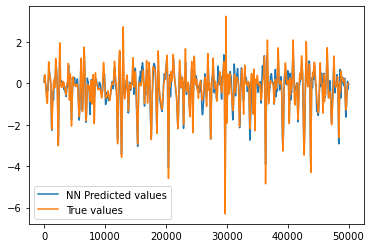

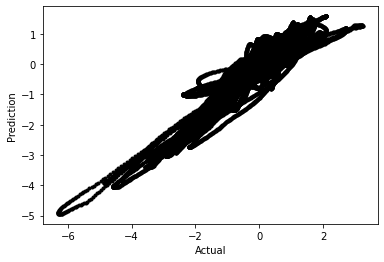

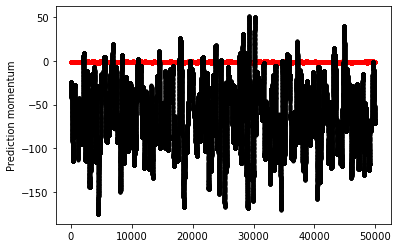

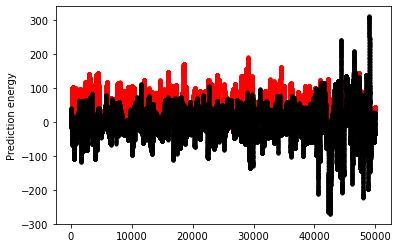

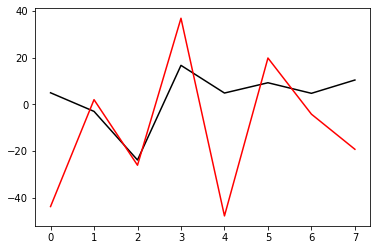

In [54]:
# The neural network does a pretty good job predicting the advection tendencies

preds22o = nn_3l_loss4(torch.from_numpy(np.array(X_S)).double())
preds22 = nn_3l_loss5(torch.from_numpy(np.array(X_S)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[:, 2], label="NN Predicted values")
plt.plot(Adv_S[:, 2], label="True values")
plt.legend()

plt.figure()
plt.plot(Adv_S[:, 2], preds22.detach().numpy()[:, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")

plt.figure()
plt.plot(np.sum(preds22o.detach().numpy(), axis=1) * Forcing, "r.")
plt.plot(np.sum(preds22.detach().numpy(), axis=1) * ScA, "k.")
plt.ylabel("Prediction momentum")

plt.figure()
plt.plot(np.sum(X * preds22o.detach().numpy() * Forcing, axis=1), "r.")
plt.plot(np.sum(X * preds22.detach().numpy() * ScA, axis=1), "k.")
plt.ylabel("Prediction energy")

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = nn_3l_loss5(torch.from_numpy(np.array(Xt / Forcing)).double()).detach().numpy()

plt.figure()
plt.plot(Advr, "k-", label="actual")
plt.plot(nnAdv * Forcing**2, "r-", label="predicted")
pass;

In [55]:
gcm_nn5 = GCM_network_S(Forcing, nn_3l_loss5)
xnn5, tnn5 = gcm_nn5(init_cond, dt, int(T / dt), nn_3l_loss5)

gcm_nn5_x10 = GCM_network_S(Forcing_x10, nn_3l_loss5)
xnn5_x10, tnn5_x10 = gcm_nn5_x10(init_cond, dt, int(T / dt), nn_3l_loss5)

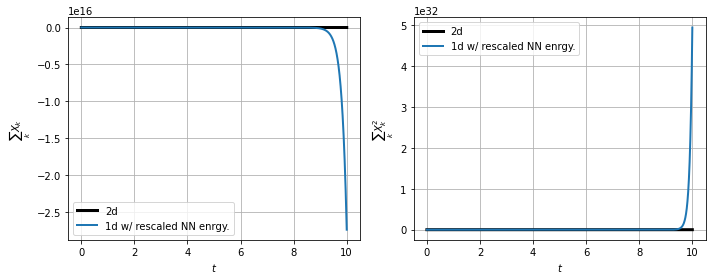

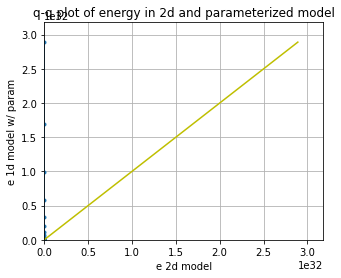

In [56]:
CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn5, xnn5, "1d w/ rescaled NN enrgy."],
    ],
)

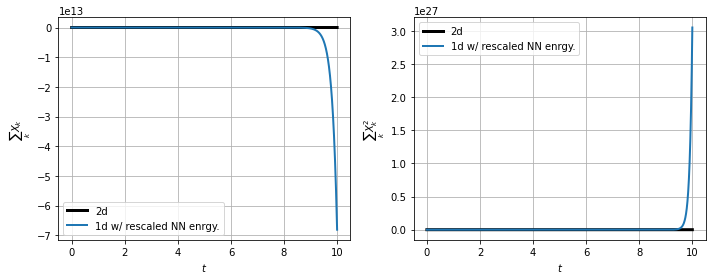

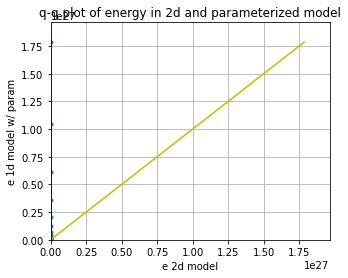

In [57]:
CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn5_x10, xnn5_x10, "1d w/ rescaled NN enrgy."],
    ],
)

train loss: 1.585038307724826
validation loss: 2.092966559306407


train loss: 1.1381337695315978
validation loss: 1.6383166335462493


train loss: 0.9946992424818617
validation loss: 1.472012596578391


train loss: 0.8907139790815984
validation loss: 1.410012592243073


train loss: 0.849063765623699
validation loss: 1.4194817066556475


train loss: 0.7934825476744516
validation loss: 1.2969275087448353


train loss: 0.8312215491846103
validation loss: 1.3436009355884102


train loss: 0.8023627200664544
validation loss: 1.4806463391935325


train loss: 0.7460234484778463
validation loss: 1.381026285111868


train loss: 0.7203596752970162
validation loss: 1.220215709891172


train loss: 0.7053125209144837
validation loss: 1.3692364659871972


train loss: 0.6735757543779392
validation loss: 1.2077118815316603


train loss: 0.6828006097709104
validation loss: 1.1928038096116644


train loss: 0.6682648670743485
validation loss: 1.3459539085790415


train loss: 0.6440764220190744
validation loss: 1.2323385370341358


train loss: 0.6617701383639676
validation loss: 1.2882893286560058


train loss: 0.6038650071861201
validation loss: 1.1987189003649605


train loss: 0.6138925696415826
validation loss: 1.2601425356716844


train loss: 0.6093593954903435
validation loss: 1.3234273504523695


train loss: 0.6549935301981988
validation loss: 1.3605877239229474


train loss: 0.5910906824423539
validation loss: 1.3943054283922276


train loss: 0.5919759099619196
validation loss: 1.295873039228481


train loss: 0.672214186306684
validation loss: 1.5880014799808675


train loss: 0.6142455253119817
validation loss: 1.47638229698862


train loss: 0.5669781329256217
validation loss: 1.2966389581033073


train loss: 0.5687064852075447
validation loss: 1.367026656610131


train loss: 0.6011513941907365
validation loss: 1.472526281279535


train loss: 0.588813943082711
validation loss: 1.2964751369849905


train loss: 0.5544506421810937
validation loss: 1.290986262064625


train loss: 0.5348717350522185
validation loss: 1.3845054747142078


train loss: 0.6065475448869786
validation loss: 1.3919649136209515


train loss: 0.5579299502721464
validation loss: 1.3462963938778547


train loss: 0.5464639360766502
validation loss: 1.4132755667897825


train loss: 0.5286859124594894
validation loss: 1.3741883280737428


train loss: 0.5328332198148009
validation loss: 1.392676551114603


train loss: 0.5273561698981113
validation loss: 1.4805936062807856


train loss: 0.5241959662131814
validation loss: 1.4418560347994474


train loss: 0.5531674075381041
validation loss: 1.5040327959243869


train loss: 0.5139822380367904
validation loss: 1.4710332587638724


train loss: 0.6243789849854622
validation loss: 1.5099576428428452


train loss: 0.5323216912097206
validation loss: 1.5195170066145678


train loss: 0.5115731687580578
validation loss: 1.3920157933592685


train loss: 0.5454534758120443
validation loss: 1.551265372442854


train loss: 0.5068791097393003
validation loss: 1.4234897965898101


train loss: 0.5501932258416733
validation loss: 1.4155276268158665


train loss: 0.5338413616646069
validation loss: 1.5761723354123052


train loss: 0.5577218831742973
validation loss: 1.3803809224368926


train loss: 0.5058850471273961
validation loss: 1.4492962691878513


train loss: 0.5325208703058404
validation loss: 1.4572281574777324


train loss: 0.4979526371466404
validation loss: 1.4248900916394318


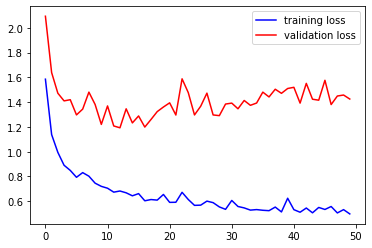

In [58]:
WT = 5

torch.manual_seed(14)  # For reproducibility
nn_3l_loss6 = Net_ANN().double()

n_epochs = 50  # Number of epocs
optimizer = optim.Adam(nn_3l_loss6.parameters(), lr=0.01)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model2(nn_3l_loss6, my_loss3, loader, optimizer)
    train_loss.append(test_model2(nn_3l_loss6, my_loss3, loader, optimizer, "train"))
    validation_loss.append(test_model2(nn_3l_loss6, my_loss3, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

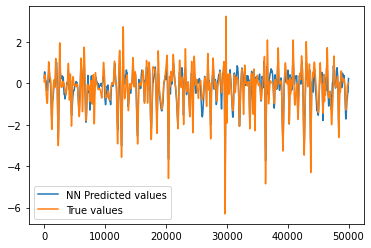

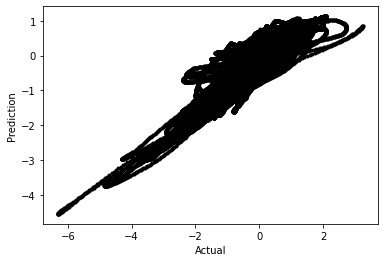

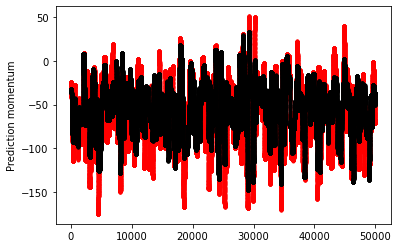

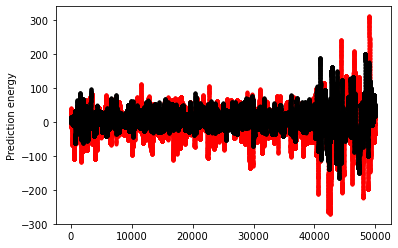

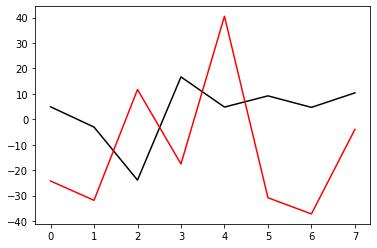

In [59]:
# The neural network does a pretty good job predicting the advection tendencies

preds22o = nn_3l_loss5(torch.from_numpy(np.array(X_S)).double())
preds22 = nn_3l_loss6(torch.from_numpy(np.array(X_S)).double())
plt.figure()
plt.plot(preds22.detach().numpy()[0:, 2], label="NN Predicted values")
plt.plot(Adv_S[:, 2], label="True values")
plt.legend()

plt.figure()
plt.plot(Adv_S[:, 2], preds22.detach().numpy()[0:, 2], "k.")
plt.xlabel("Actual")
plt.ylabel("Prediction")

plt.figure()
plt.plot(np.sum(preds22o.detach().numpy(), axis=1) * ScA, "r.")
plt.plot(np.sum(preds22.detach().numpy(), axis=1) * ScA, "k.")
plt.ylabel("Prediction momentum")

plt.figure()
plt.plot(np.sum(X * preds22o.detach().numpy(), axis=1) * ScA, "r.")
plt.plot(np.sum(X * preds22.detach().numpy(), axis=1) * ScA, "k.")
plt.ylabel("Prediction energy")

Xt = init_cond
Advr = -np.roll(Xt, 1) * (np.roll(Xt, 2) - np.roll(Xt, -1))
nnAdv = nn_3l_loss6(torch.from_numpy(np.array(Xt / Forcing)).double()).detach().numpy()

plt.figure()
plt.plot(Advr, "k-", label="actual")
plt.plot(nnAdv * Forcing**2, "r-", label="predicted")
pass;

In [60]:
gcm_nn6 = GCM_network_S(Forcing, nn_3l_loss6)
xnn6, tnn6 = gcm_nn6(init_cond, dt, int(50 / dt), nn_3l_loss6)

gcm_nn6_x10 = GCM_network_S(Forcing_x10, nn_3l_loss6)
xnn6_x10, tnn6_x10 = gcm_nn6_x10(init_cond, dt, int(5 / dt), nn_3l_loss6)

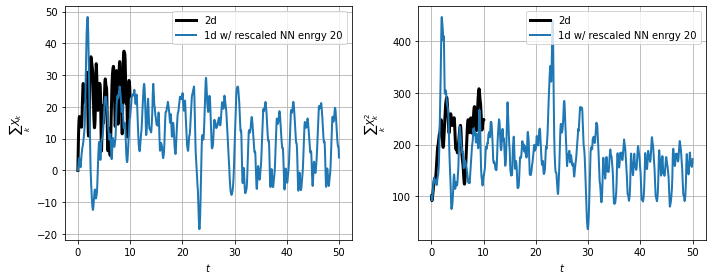

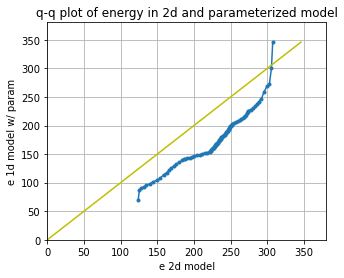

In [61]:
CompExps(
    [t2d, x2d, "2d"],
    [
        [tnn6, xnn6, "1d w/ rescaled NN enrgy 20"],
    ],
)

/tmp/ipykernel_2667/2792372065.py:13: RuntimeWarning: overflow encountered in square
  a.plot(T1, np.sum(X1**2, axis=1), label=L1, color="k", linewidth=3)


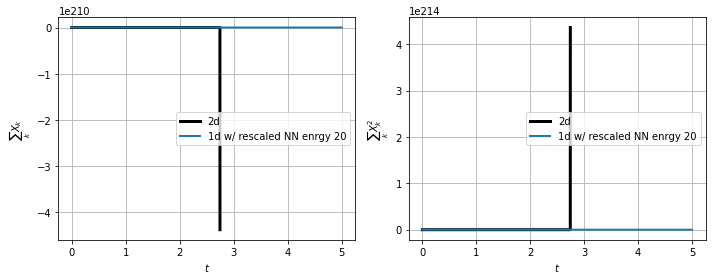

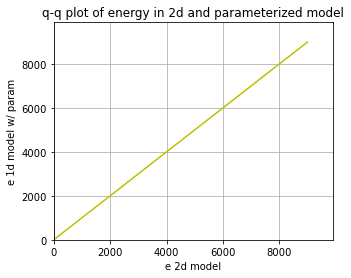

In [62]:
CompExps(
    [t2d_x10, x2d_x10, "2d"],
    [
        [tnn6_x10, xnn6_x10, "1d w/ rescaled NN enrgy 20"],
    ],
)